In [1]:
from earlyexitnet.training_tools.train import get_model
from earlyexitnet.tools import load_model, CIFAR10DataColl
import torch
import os

model_path = '../../trained_models/b_lenet_cifar10.pth'
model_name = "b_lenet_cifar"
data_set = "cifar10"
device = 'cuda:1'

# model_path = '../../earlyexitnet/trained_models/resnet8_2ee_230721.pth'
# model_name = "resnet8_2ee"
model = get_model(model_name)
load_model(model, model_path, device=torch.device(device))

Model done: b_lenet_cifar


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
#plt.switch_backend('WebAgg')
#%matplotlib widget
import numpy as np

BATCH_SIZE = 5000
TEST_BS = 10000

datacoll = CIFAR10DataColl(batch_size_train=BATCH_SIZE, batch_size_test=TEST_BS, v_split=0.2, num_workers=16)

from earlyexitnet.testing_tools.test import Tester
import json
from datetime import datetime as dt


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# run the test now? or load a previous one?
run_test=False
#run_test=True


if run_test:
    train_dl = datacoll.get_train_dl() # get dataloader
    
    tester = Tester(model, train_dl, exits=2, 
                    conf_funcs=None, 
                    top1acc_thresholds=[0.6,0],
                    entropy_thresholds=[0.2, 1000000],
                    device=torch.device(device), save_raw=True)
    
    tester.test()
    
    test_res = tester.get_stats()
    
    # add the model name and dataset
    test_res["model"] = model_name
    test_res["model_path"] = model_path
    test_res["dataset"] = data_set
    
    timestamp = dt.now().strftime("%Y-%m-%d_%H%M%S")
    
    save_path = f'../../model-outputs/{model_name}/'
    save_name = f'cifar10_raw_train_output_{timestamp}.json'
    full_dest = os.path.join(save_path, save_name)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    with open(full_dest,'w') as file:
            file.write(json.dumps(test_res))
else:
    json_file = f'../../model-outputs/{model_name}/cifar10_raw_train_output_2025-01-14_144838.json'
    full_dest = json_file
    with open(json_file) as json_data:
        test_res = json.load(json_data)

In [4]:
# load the raw outputs from the model
raw_results = torch.Tensor(test_res['raw_layer'])
# load the ground truth index for each class
ground_truth = torch.Tensor(test_res['true_indices'])

# compare the results to the ground truth, provides bool mask
correct_predictions = (raw_results.argmax(-1) == ground_truth)
# 2 exits by num inputs, 2 exits by num samples by last linear layer output(NOT sftmax)
correct_predictions.shape, raw_results.shape

(torch.Size([2, 40000]), torch.Size([2, 40000, 10]))

In [5]:
import earlyexitnet.data_analysis.graphs as hp

classes_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

conf_list = [
        "_thr_entropy",
        "_thr_max_softmax",
        "_thr_max_softmax_fast",
        "_thr_max_softmax_fast_noTrunc",
        "_thr_max_softmax_fast_sub",
        "_thr_max_softmax_fast_sub_bitAcc"
]
#top1_sftmx = torch.Tensor(test_res['conf_metrics']['_thr_max_softmax']['raw_softmax'])

rr = raw_results.numpy() # [exits, batch size, class dist]

# individual inputs raw results over 10 classes seems to get spread across the indices
# meaning that the 0,0,0 = 0,0 BUT 0,0,1 = 0,40000
# this has the effect of grouping each logit index with the others, duplicating a lot of info

flattened = rr.swapaxes(1,2).reshape(2,-1)
chosen_class = np.concatenate((rr.argmax(-1).copy(), rr.argmax(-1).copy()), axis=-1)
index = np.concatenate((np.full((2,40000), 0), np.full((2,40000), 1)), axis=-1)
correct_classif = np.concatenate((correct_predictions, correct_predictions), axis=-1)
for i in range(10-2):
    chosen_class = np.concatenate(
        (chosen_class, rr.argmax(-1)), axis=-1
    )
    index = np.concatenate(
        (index, np.full((2,40000), i+2)), axis=-1
    )
    correct_classif = np.concatenate(
        (correct_classif, correct_predictions), axis=-1
    )

# [class index of this raw value from logit, raw logit value, chosen class (from argmax), misclassified (0 is incorrect, 1 is correct)
comb = np.stack(
    (index, flattened, chosen_class, correct_classif), -1
)

classes_grouped = hp.group_by(comb)

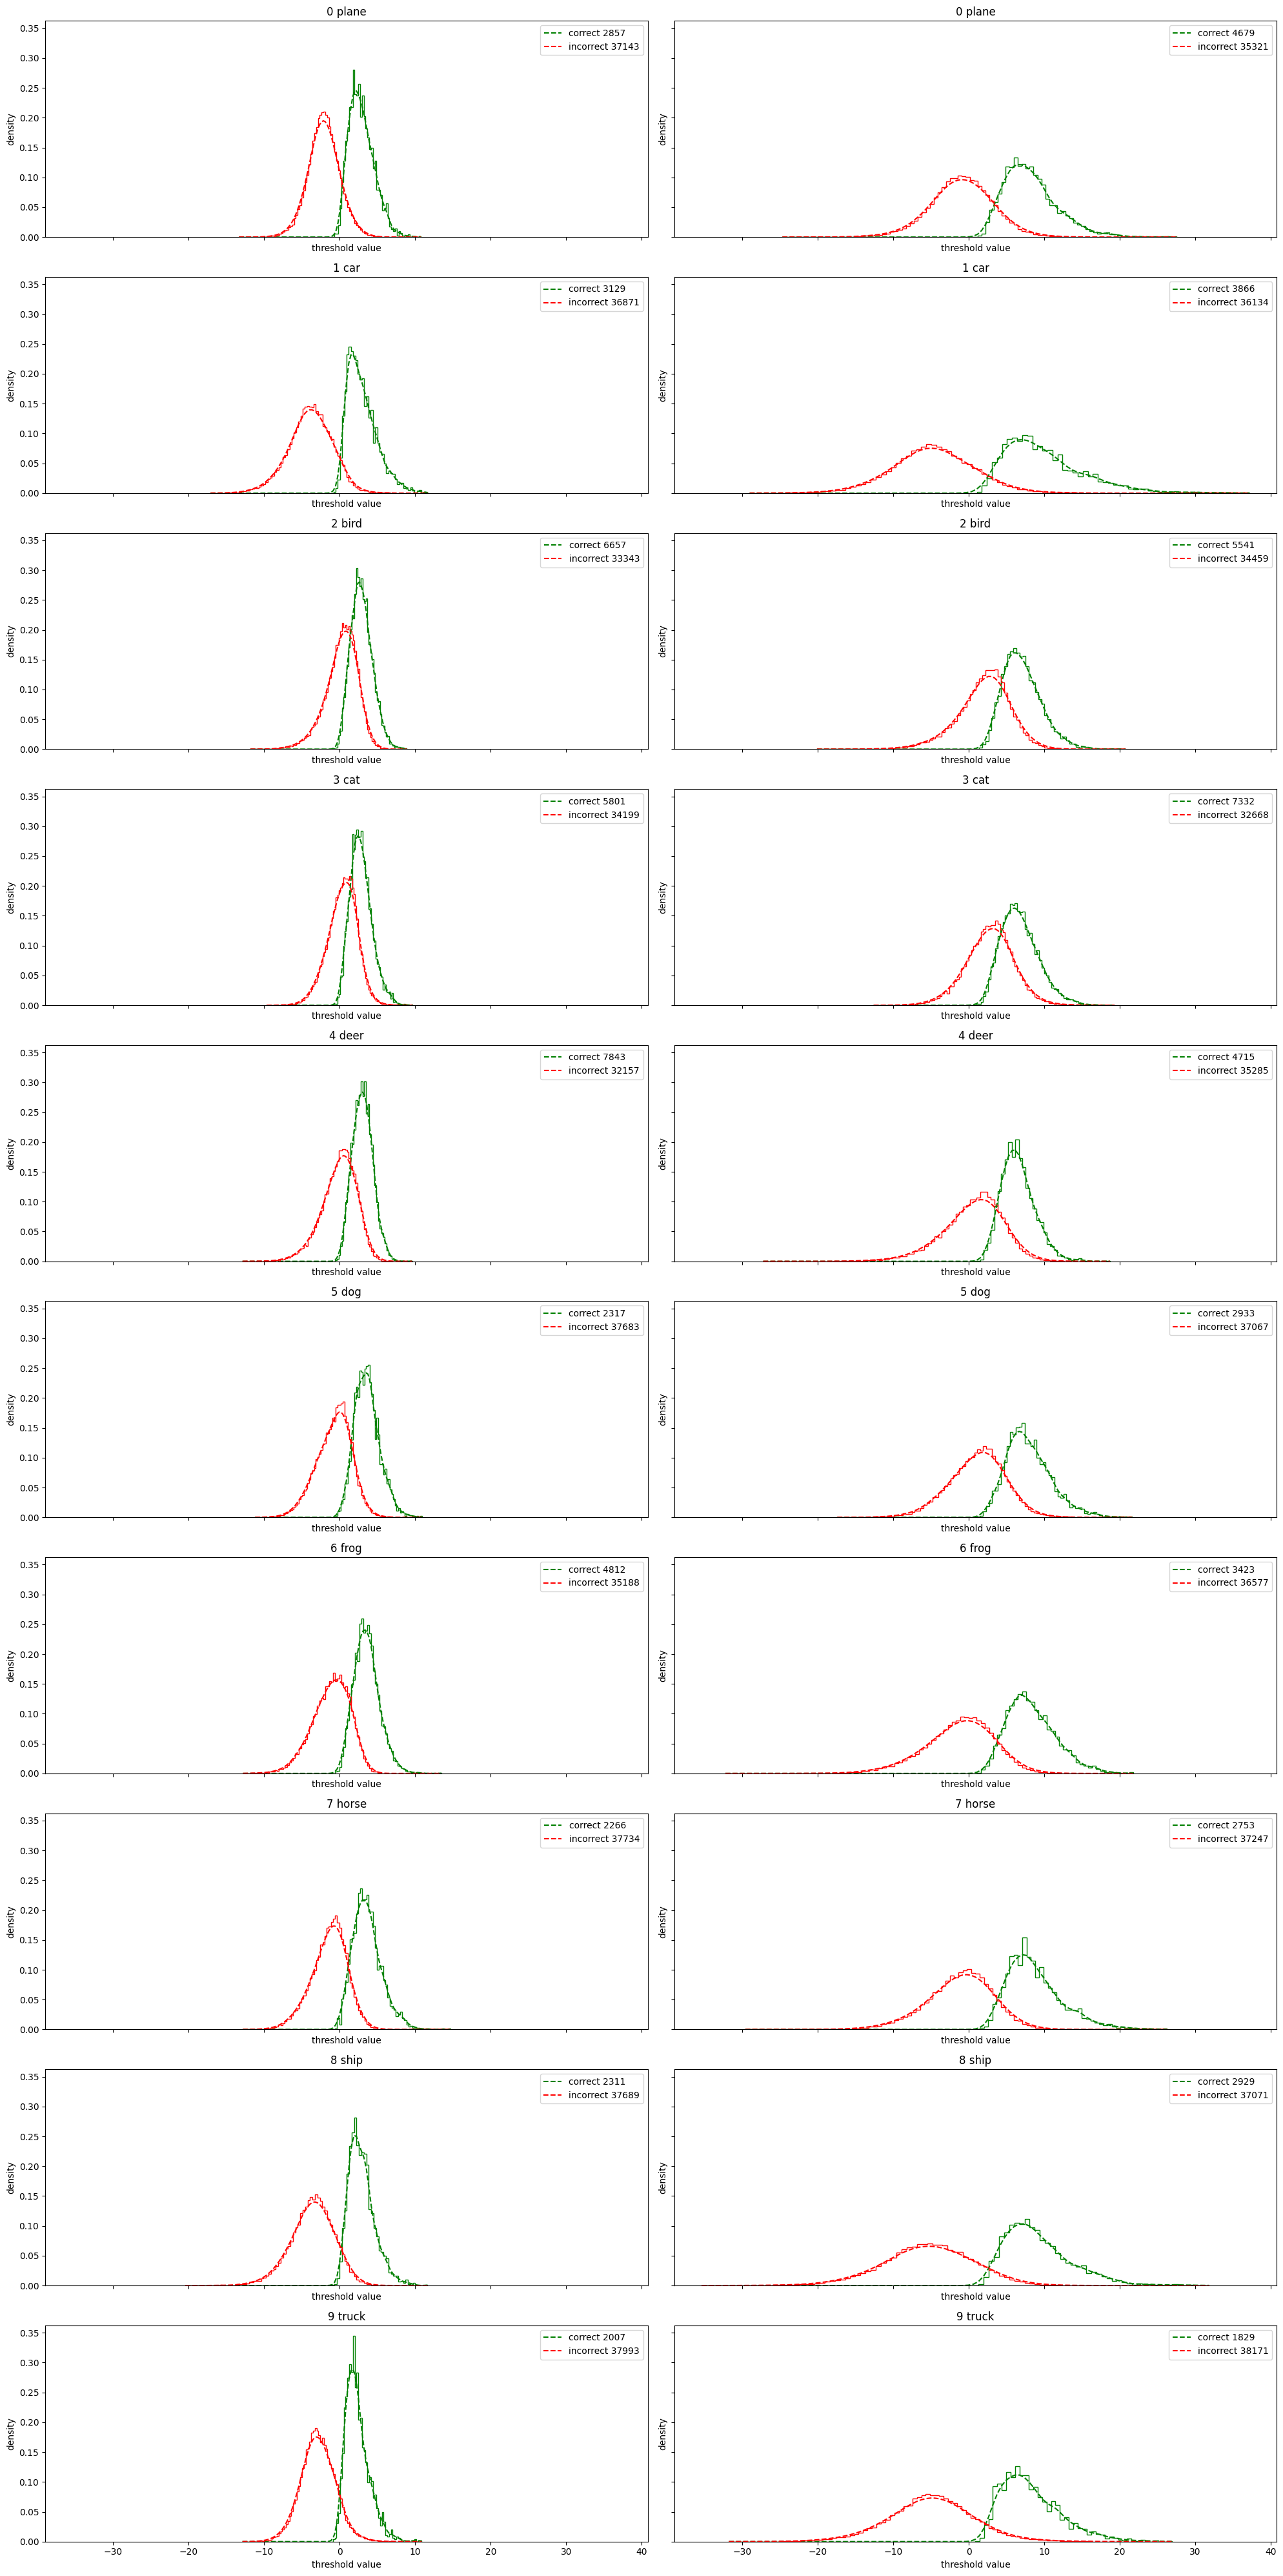

In [6]:
#import helper.graphs as hp
#%matplotlib widget
#from importlib import reload
#reload(hp)

#early_exit = classes_grouped[0]
# print(early_exit[0])
num_exits=2
num_classes=10

fig, ax_grp = plt.subplots(nrows=10,ncols=2, sharex=True, sharey=True)
print("")

for k, ex in enumerate(classes_grouped):
    for i, rec_class in enumerate(ex):
        # set ax to be working on
        ax = ax_grp[i][k]
        # make numpy array
        rec_class = np.array(rec_class)
        # plot all values produce by single class output
        hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None)

        # hmm not sure exactly what this is doing
        wrong_class = rec_class[np.invert(np.array(rec_class[:,2],dtype=bool))]
        ismax = np.array(wrong_class[:,1]) == i
        #hp.plot_hist_kernel(ax, wrong_class[:,0][ismax], label=f"{i} {classes_labels[i]} wrong", hist=False)

        # hmm not sure exactly what this is doing
        right_class = rec_class[np.array(rec_class[:,2],dtype=bool)]
        ismax = np.array(right_class[:,1]) == i
        #hp.plot_hist_kernel(ax, right_class[:,0][ismax], label=f"{i} {classes_labels[i]} right", hist=False, ls='-')
        
        ax.set_title(f"{i} {classes_labels[i]}")
        ax.legend()
fig.set_size_inches(10 * num_exits, 4 * num_classes)
fig.tight_layout()
plt.show()

# some observations - deer and cat are the hardest classes judging by the amount of overlap 
# future work is per-class thresholds

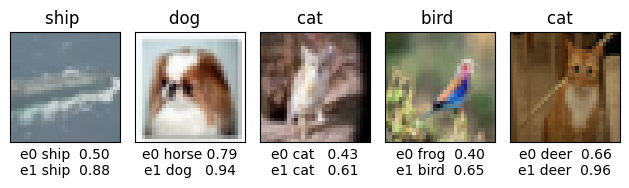

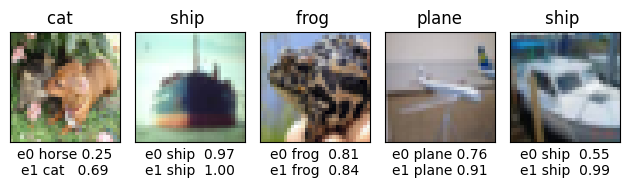

In [7]:
# SHOW THE MODEL WORKING
# %matplotlib ipympl needs ipywidgets
import math
from IPython.core.debugger import set_trace

test_dl = datacoll.get_test_dl()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, ncols=1, label=None, caption=None):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.to('cpu').numpy()
    num_img = npimg.shape[0]
    
    nrows = math.ceil(num_img / ncols)
    
    img_track = 0
    
    for row in range(nrows):
        fig, axs = plt.subplots(nrows=1, ncols=ncols,
                                subplot_kw={'xticks': [], 'yticks': []})

        if row > 5:
            break
        
        for ax in axs:
            if img_track < num_img:
                ax.imshow(np.transpose(npimg[img_track], (1, 2, 0)))
                if label is not None:
                    ax.set_title(label[img_track])
                if caption is not None:
                    ax.set_xlabel(caption[img_track])
            img_track += 1
            
        plt.tight_layout()
        # plt.imshow(np.transpose(npimg, (1, 1, 1)))
        plt.show()

def getcaption(images, model):
    model.eval()
    #captions = ['' for i in range(BATCH_SIZE)]
    captions = ['' for i in range(10)]
    with torch.no_grad():
        result = model.forward(images)
        sftmx = torch.max(torch.softmax(result, dim=-1),dim=-1).values
        res_max = result.max(dim=-1).values
        res_arg_max = result.max(dim=-1).indices
        for exit_num, (max, arg_max) in enumerate(zip(sftmx, res_arg_max)):
            for i, (max_val, index) in enumerate(zip(max, arg_max)):
                captions[i] += f"e{exit_num} {classes[index]:5s} {max_val:.02f}"
                if exit_num != model.exit_num - 1:
                    captions[i] += '\n'
    return captions
# get some random training images
dataiter = iter(test_dl)
images, labels = next(dataiter)
images.shape, labels.shape
images[:10].shape, labels[:10]



if run_test:
    images = images[:10].to(device)
    labels = labels[:10].to(device)
else:
    images = images[:10]
    labels = labels[:10]

# show images
imshow(images, ncols=5, label=[f'{classes[label]:5s}' for label in labels], caption=getcaption(images, model))


In [13]:
##### Confusion matrix #####
# (my version at least)

# quadrant definitions:
# tp, true positive - when an early exit occurs and the classification is correct
# fp, false positive - when an early exit occurs and the classification is incorrect
    # query - do I include ee=true && ee_c == fe_c, ee classif equals final exit classif
    # in that case it is positive since avoid wasting compute on something that will be wrong anyway?
    # maybe the above should go in true +ve
# tn, true negative - when an early exit DOES NOT OCCUR and the classification is wrong
    # similar query - does tn include ee=false 77 ee_c == fe=c or does that go in tp??
# fn, false negative - ee=false && ee_c == correct
    # query - this is bad but even worse is the case: ee=false && ee_c == correct && fe_c != correct

conf_list = [
        "_thr_entropy",
        "_thr_max_softmax",
        "_thr_max_softmax_fast",
        "_thr_max_softmax_fast_noTrunc",
        "_thr_max_softmax_fast_sub",
        "_thr_max_softmax_fast_sub_bitAcc"
]


print(test_res.keys())
print(test_res['accu_per_exit'])

for conf in test_res['conf_metrics'].keys():
    print(f"conf metric stats: {conf}")
    for k in test_res['conf_metrics'][conf].keys():
        if k == 'raw_softmax':
            continue
        print(f"\t{k} :\t{test_res['conf_metrics'][conf][k]}")

standard_softmax = torch.tensor(test_res['conf_metrics']['_thr_max_softmax']['raw_softmax'])
print(standard_softmax.shape)

pow2_truc_softmax = torch.tensor(test_res['conf_metrics']["_thr_max_softmax_fast"]['raw_softmax'])
print(pow2_truc_softmax.shape)

# simple check to see if they pick the same values
std_sft_ee_cl = standard_softmax[0].argmax(-1)
print(std_sft_ee_cl)

p2tr_sft_ee_cl = pow2_truc_softmax[0].argmax(-1)
print(p2tr_sft_ee_cl)

# sanity checking that there is a difference between two conf functions
diff_idx = []
for i, (std, p2tr) in enumerate(zip(std_sft_ee_cl, p2tr_sft_ee_cl)):
    if std != p2tr:
        # get the sample number within the batch in which the values differ
        # doesn't necessarily mean that the classif will be different?
        diff_idx.append(i)

diff_idx_tensor = torch.tensor(diff_idx)
diff_idx_tensor.shape

# There is difference! 
# I reckon this is from the truncation, two class values are very close to each other
# same order of magnitude but with one slightly higher, selection will default to the lowest index
# same thing would happen in HW I assume

# will be interesting to see if this results in a significant accuracy change or not
# it is quite a lot of samples? but probably depends on how good the classifier is anyway

print(test_res.keys())
print(test_res['conf_metrics'].keys())
print(test_res['conf_metrics']['_thr_entropy'].keys())

subting = torch.tensor(test_res['conf_metrics']['_thr_max_softmax_fast_sub']['raw_softmax'])
print(standard_softmax.argmax(-1))
print(pow2_truc_softmax.argmax(-1))
subting.argmax(-1)

dict_keys(['conf_metrics', 'num_exits', 'num_samples', 'batch_size', 'accu_per_exit', 'true_indices', 'raw_layer', 'model', 'model_path', 'dataset'])
[0.48215, 0.481425]
conf metric stats: _thr_entropy
	exit_pc :	[0.034525, 0.965475]
	accu_pc :	[0.9304851556842868, 0.4676713534788576]
	exit_threshs :	[0.2, 1000000]
	combined_accuracy :	0.48365
conf metric stats: _thr_max_softmax
	exit_pc :	[0.4025, 0.5975]
	accu_pc :	[0.6737888198757764, 0.39656903765690377]
	exit_threshs :	[0.6, 0]
	combined_accuracy :	0.5081500000000001
conf metric stats: _thr_max_softmax_fast
	exit_pc :	[0.171625, 0.828375]
	accu_pc :	[0.7965040058266569, 0.43401237362305717]
	exit_threshs :	[0.6, 0]
	combined_accuracy :	0.49622499999999997
conf metric stats: _thr_max_softmax_fast_noTrunc
	exit_pc :	[0.209225, 0.790775]
	accu_pc :	[0.7788266220575935, 0.42584806044702983]
	exit_threshs :	[0.6, 0]
	combined_accuracy :	0.4997
conf metric stats: _thr_max_softmax_fast_sub
	exit_pc :	[0.1354, 0.8646]
	accu_pc :	[0.839918

tensor([[2, 2, 2,  ..., 5, 0, 2],
        [2, 3, 2,  ..., 5, 0, 3]])

Running analysis on different confidence functions
Confidence function 0: entropy
Confidence function 1: max_softmax
Confidence function 2: max_softmax_fast
Confidence function 3: max_softmax_fast_noTrunc
Confidence function 4: max_softmax_fast_sub
Found a sub! max_softmax_fast_sub
Confidence function 5: max_softmax_fast_sub_bitAcc
Found a sub! max_softmax_fast_sub_bitAcc
Confidence function 6: DOCTOR_distance_softmax
Found the Doctor! DOCTOR_distance_softmax
Confidence function 7: DOCTOR_distance_raw
Found the Doctor! DOCTOR_distance_raw
Confidence function 8: DOCTOR_dist_top2_softmax
Found the Doctor! DOCTOR_dist_top2_softmax


/home/bb2515/miniconda3/envs/ee_gpu_py39/lib/python3.10/site-packages/earlyexitnet/data_analysis/softmax_comparison.py:396: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


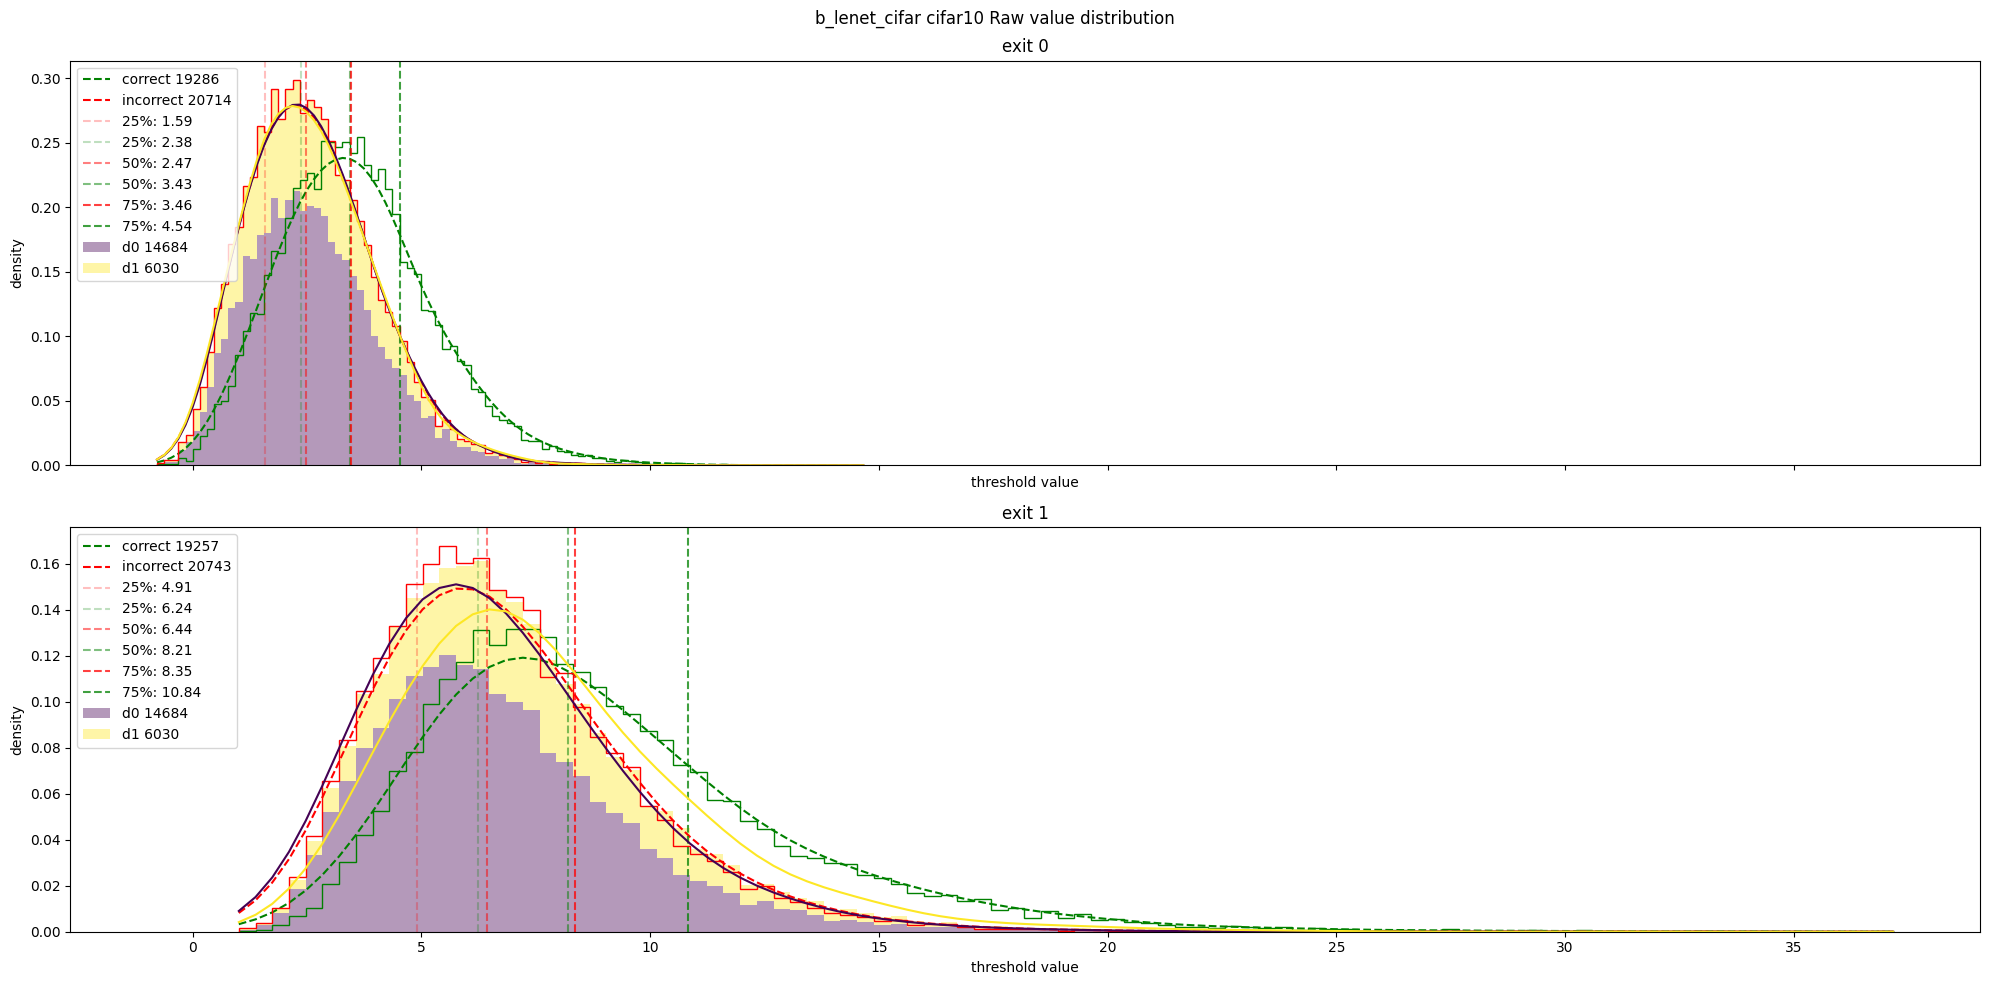

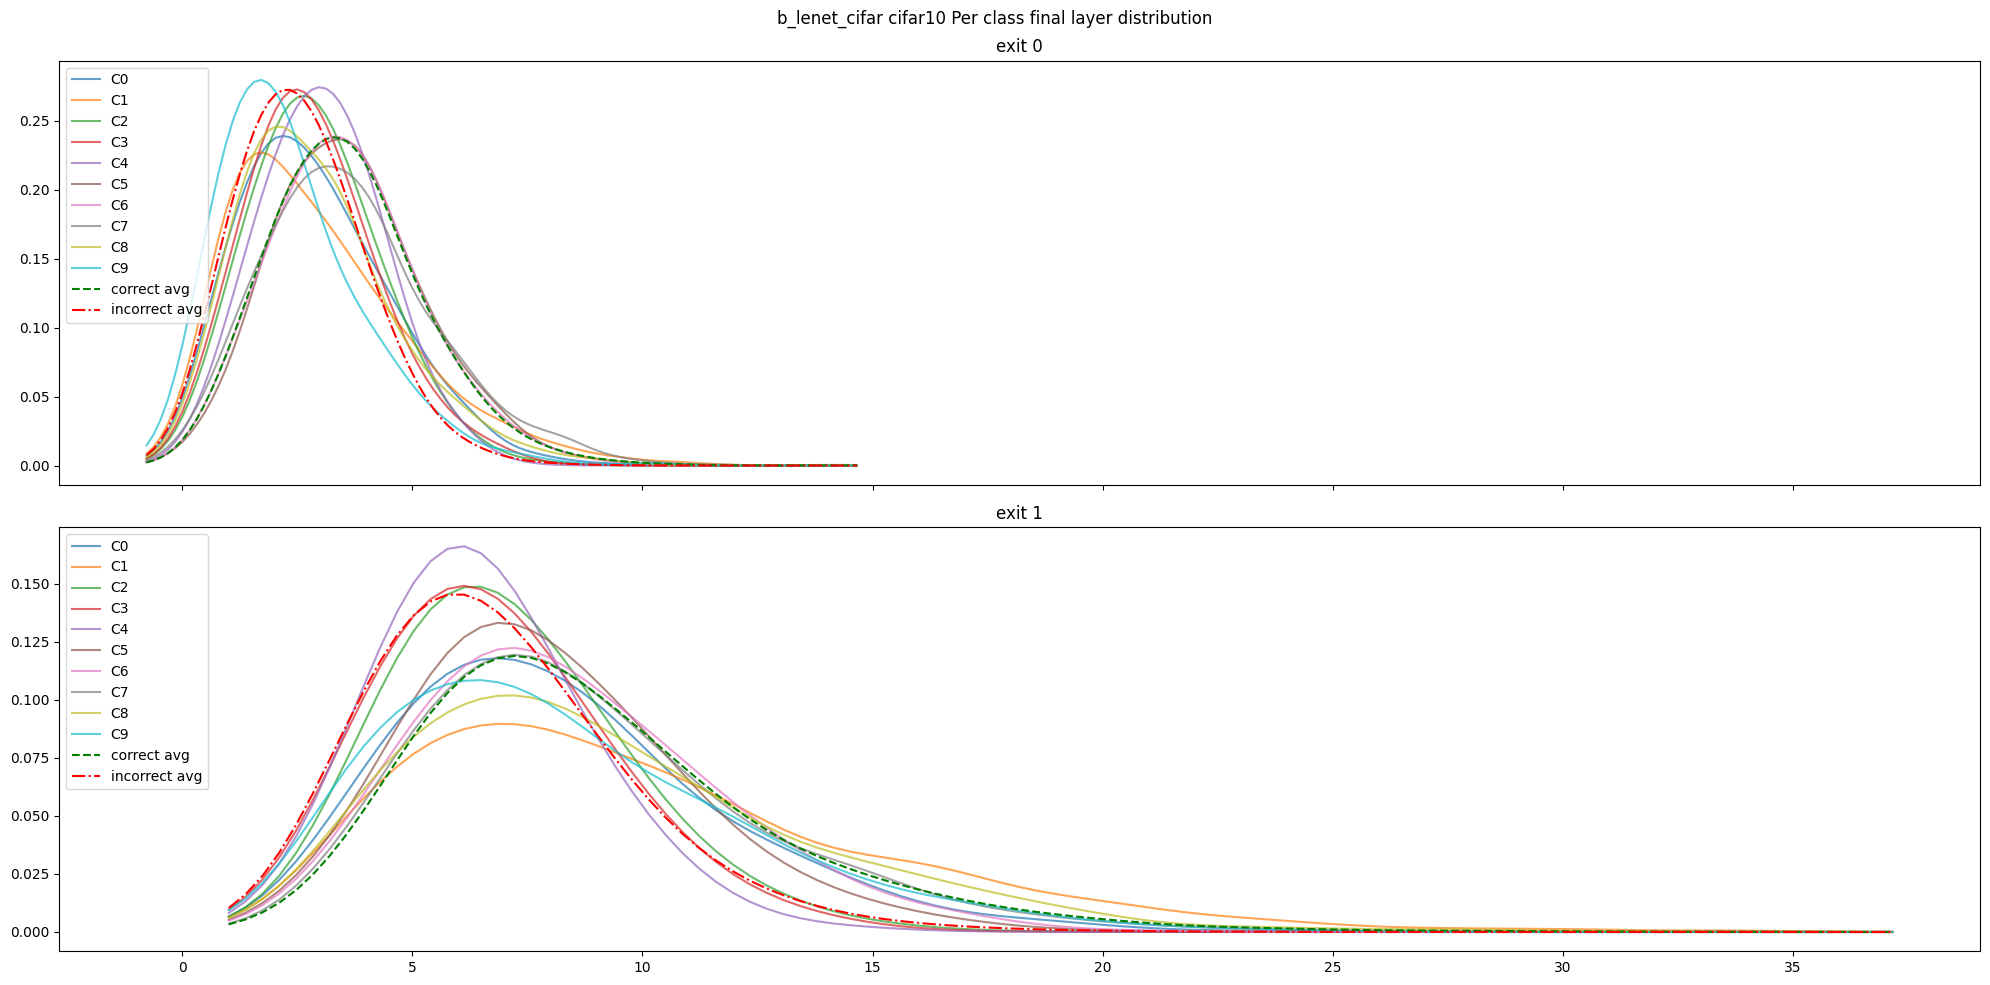

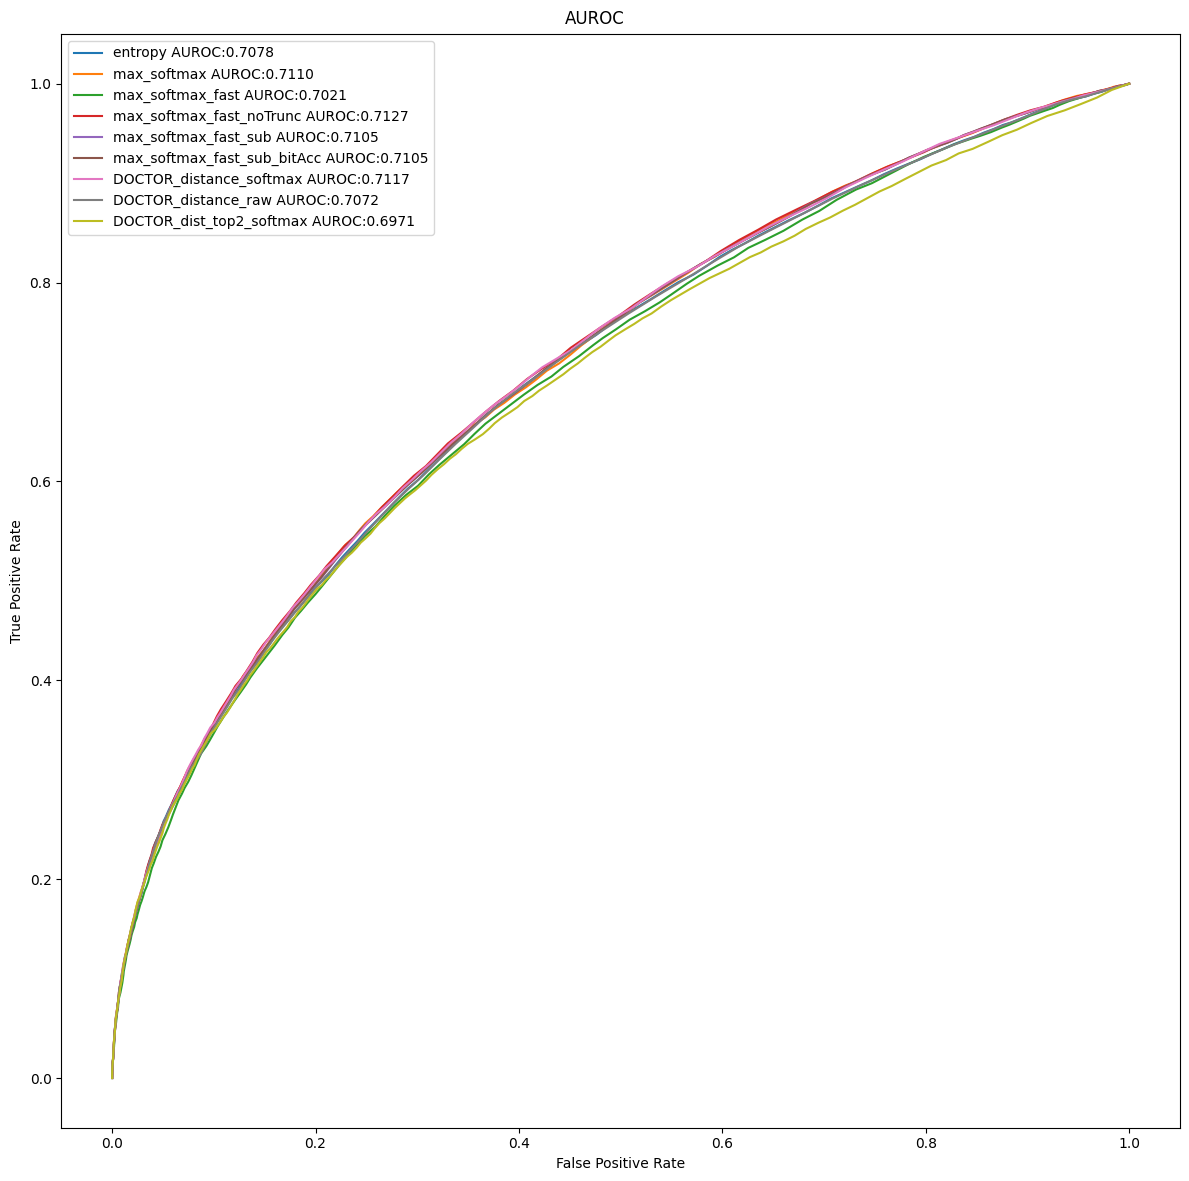

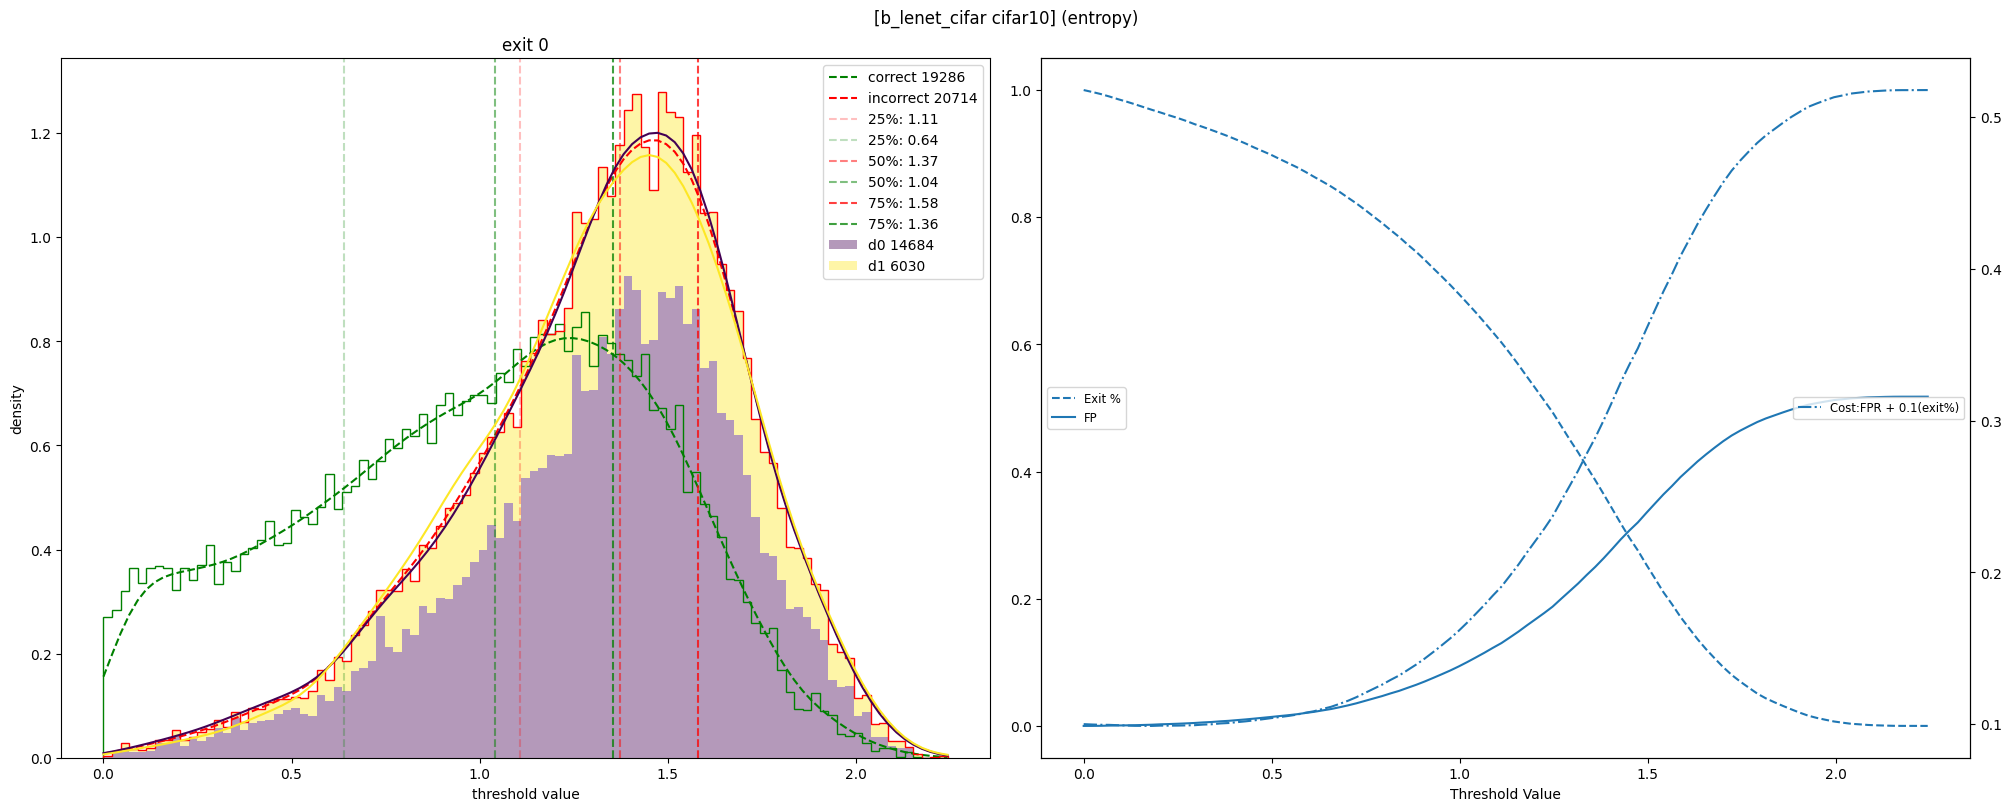

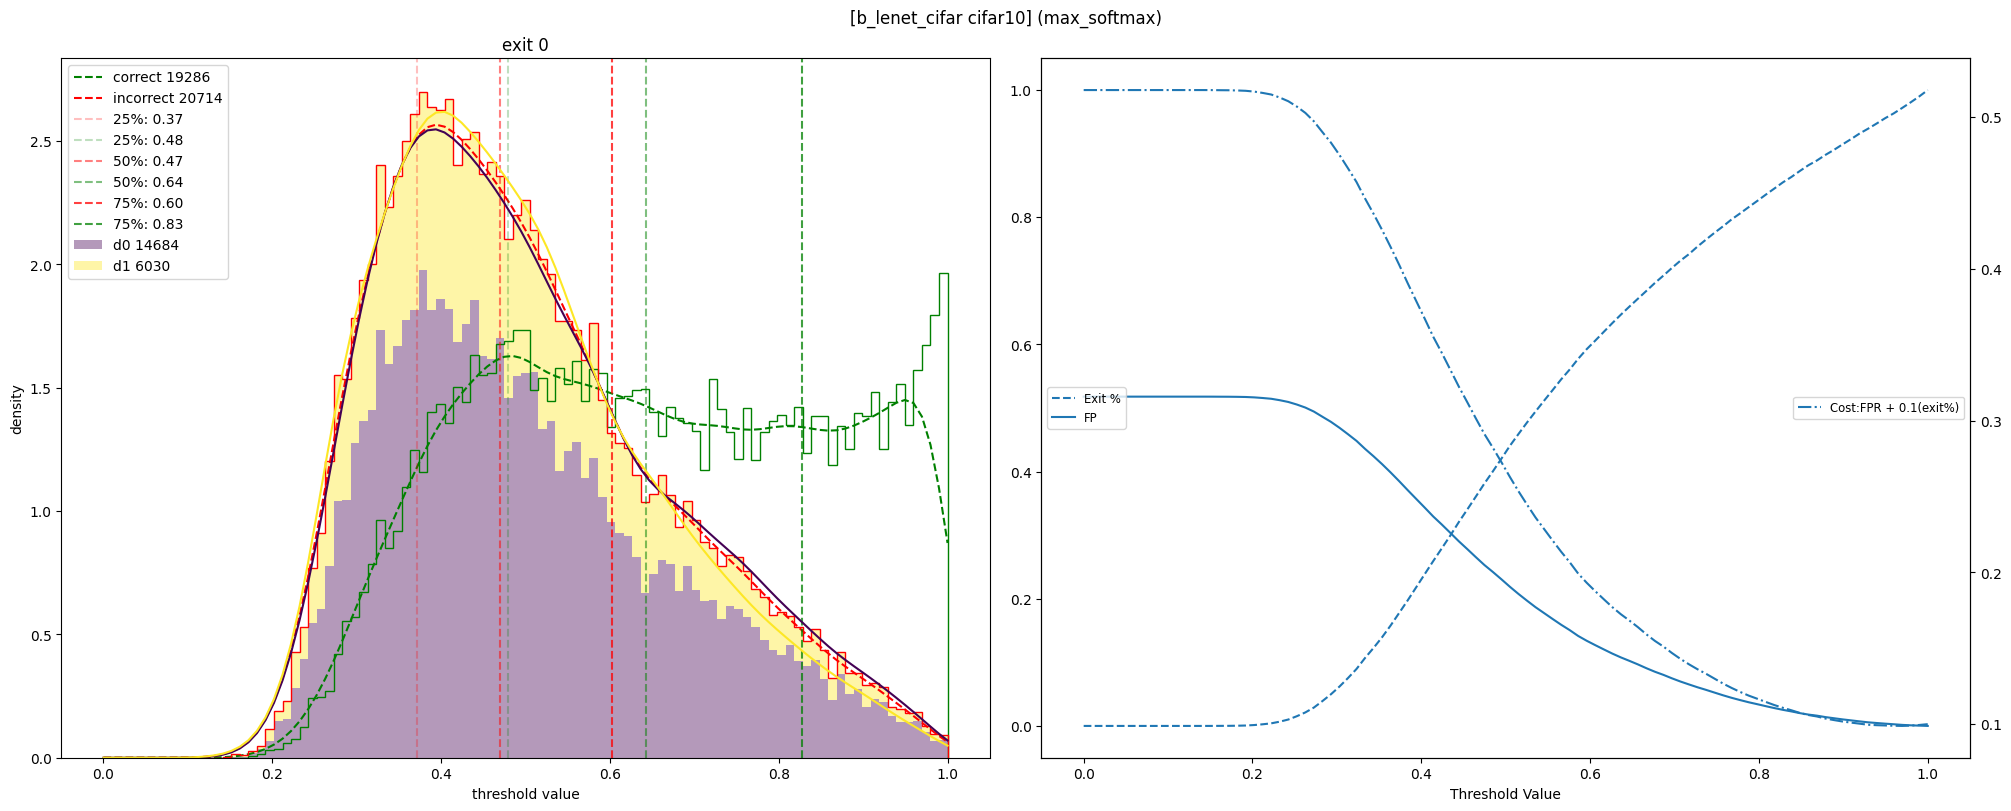

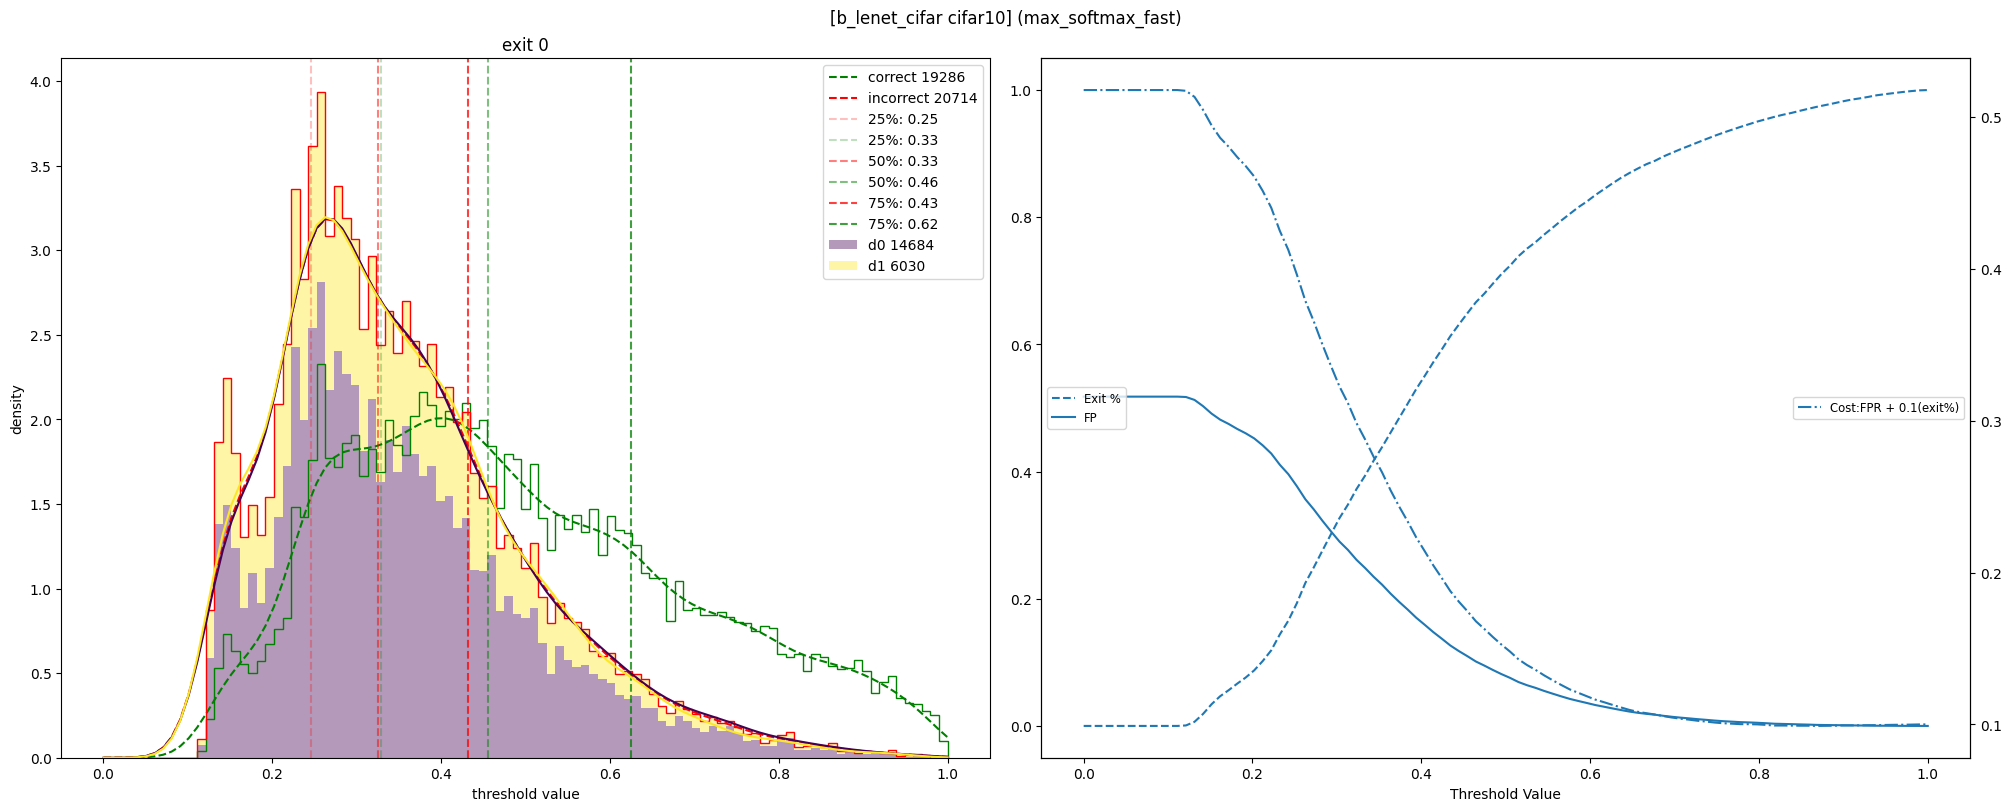

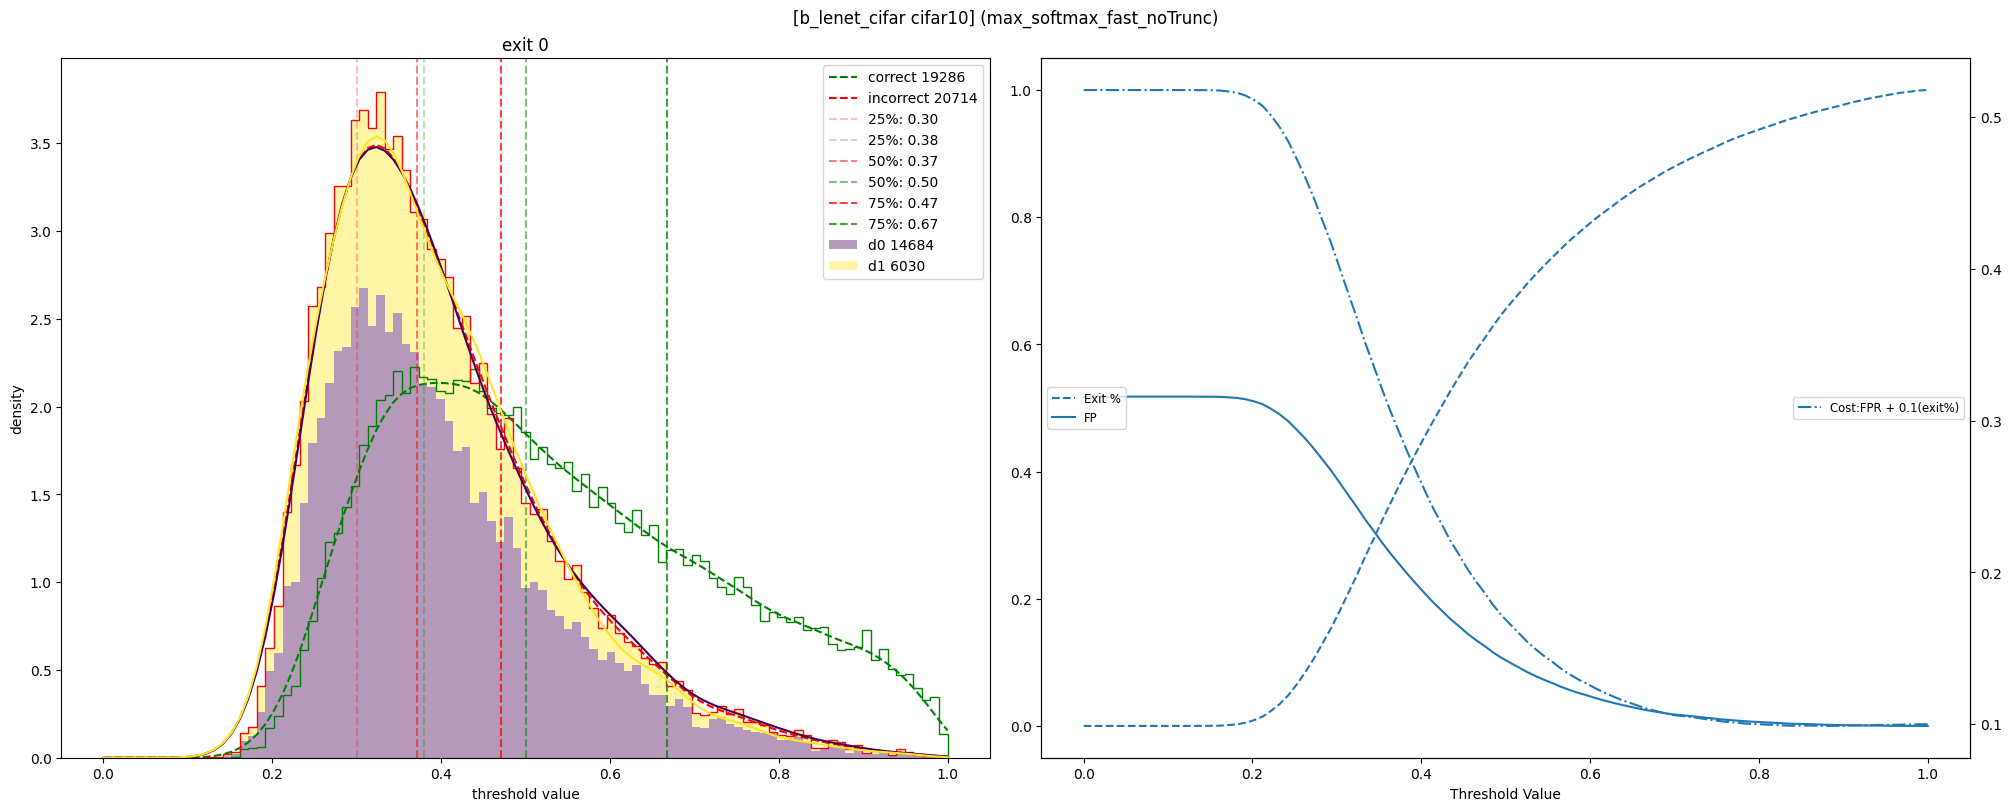

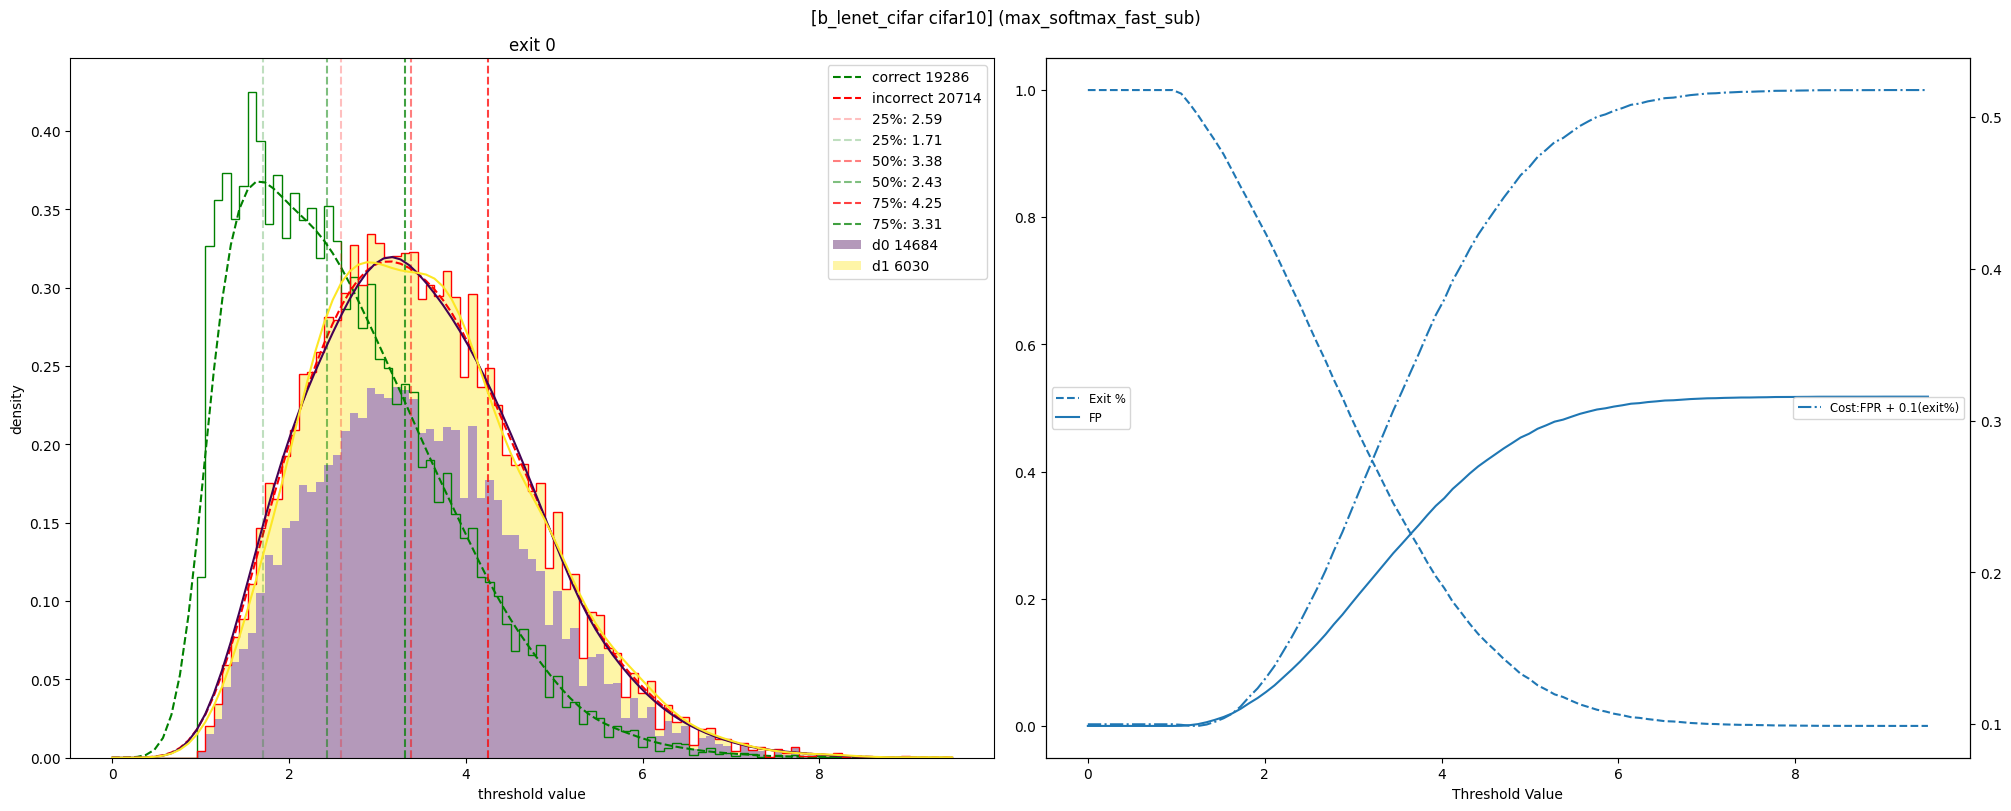

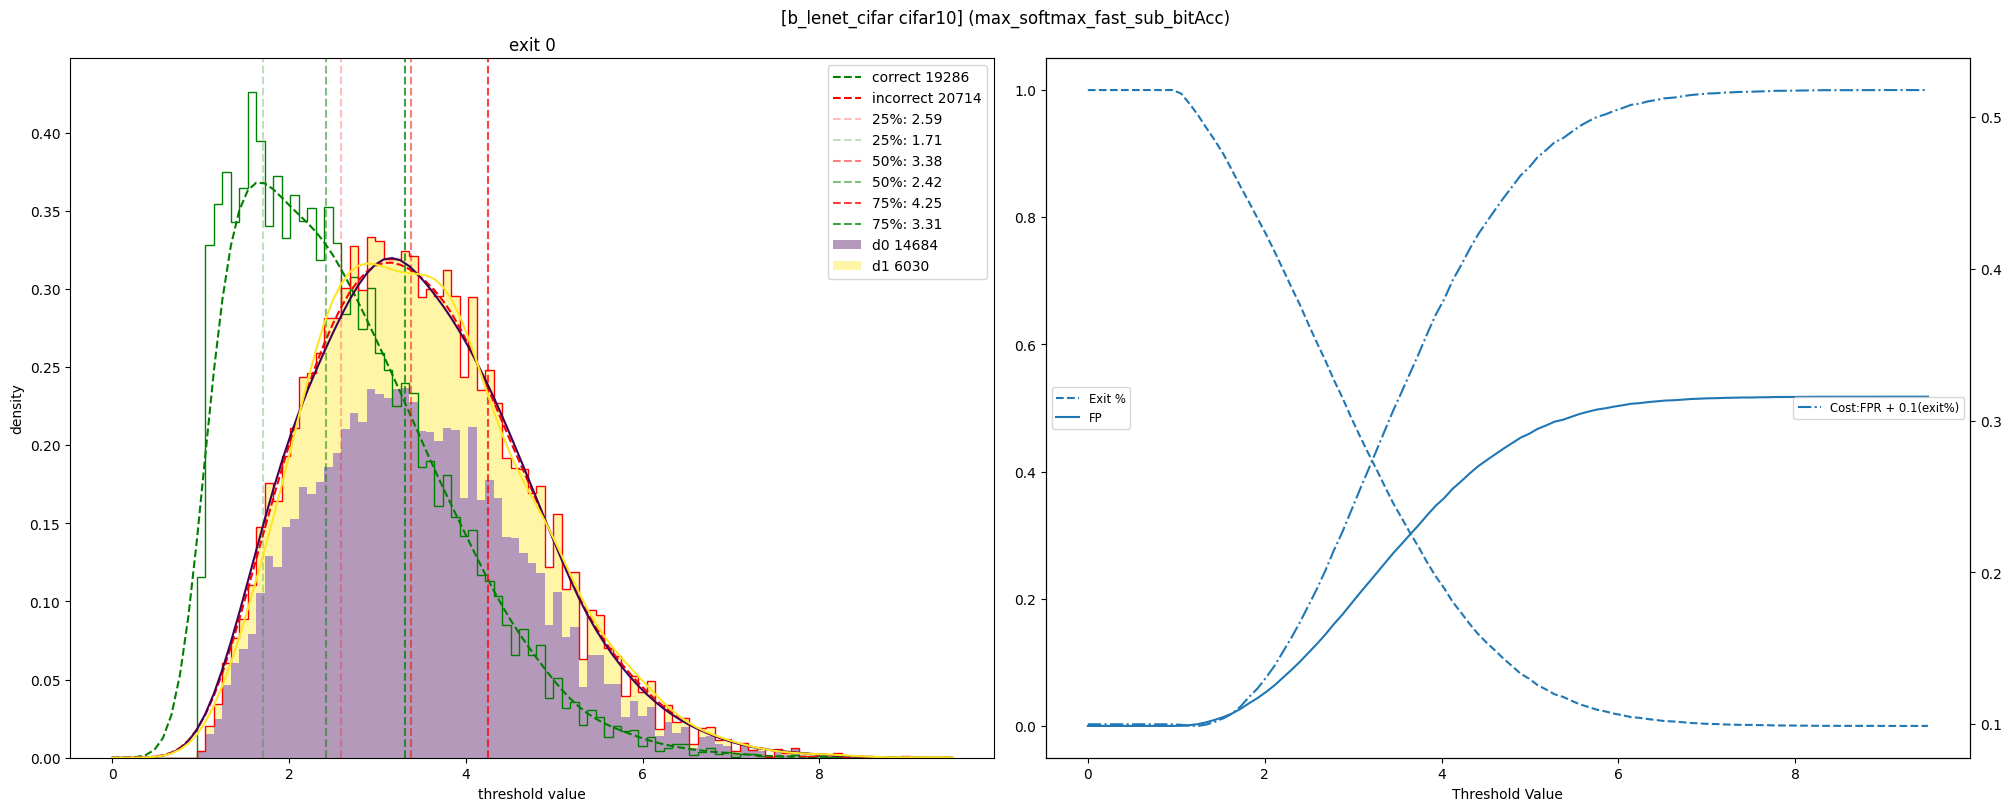

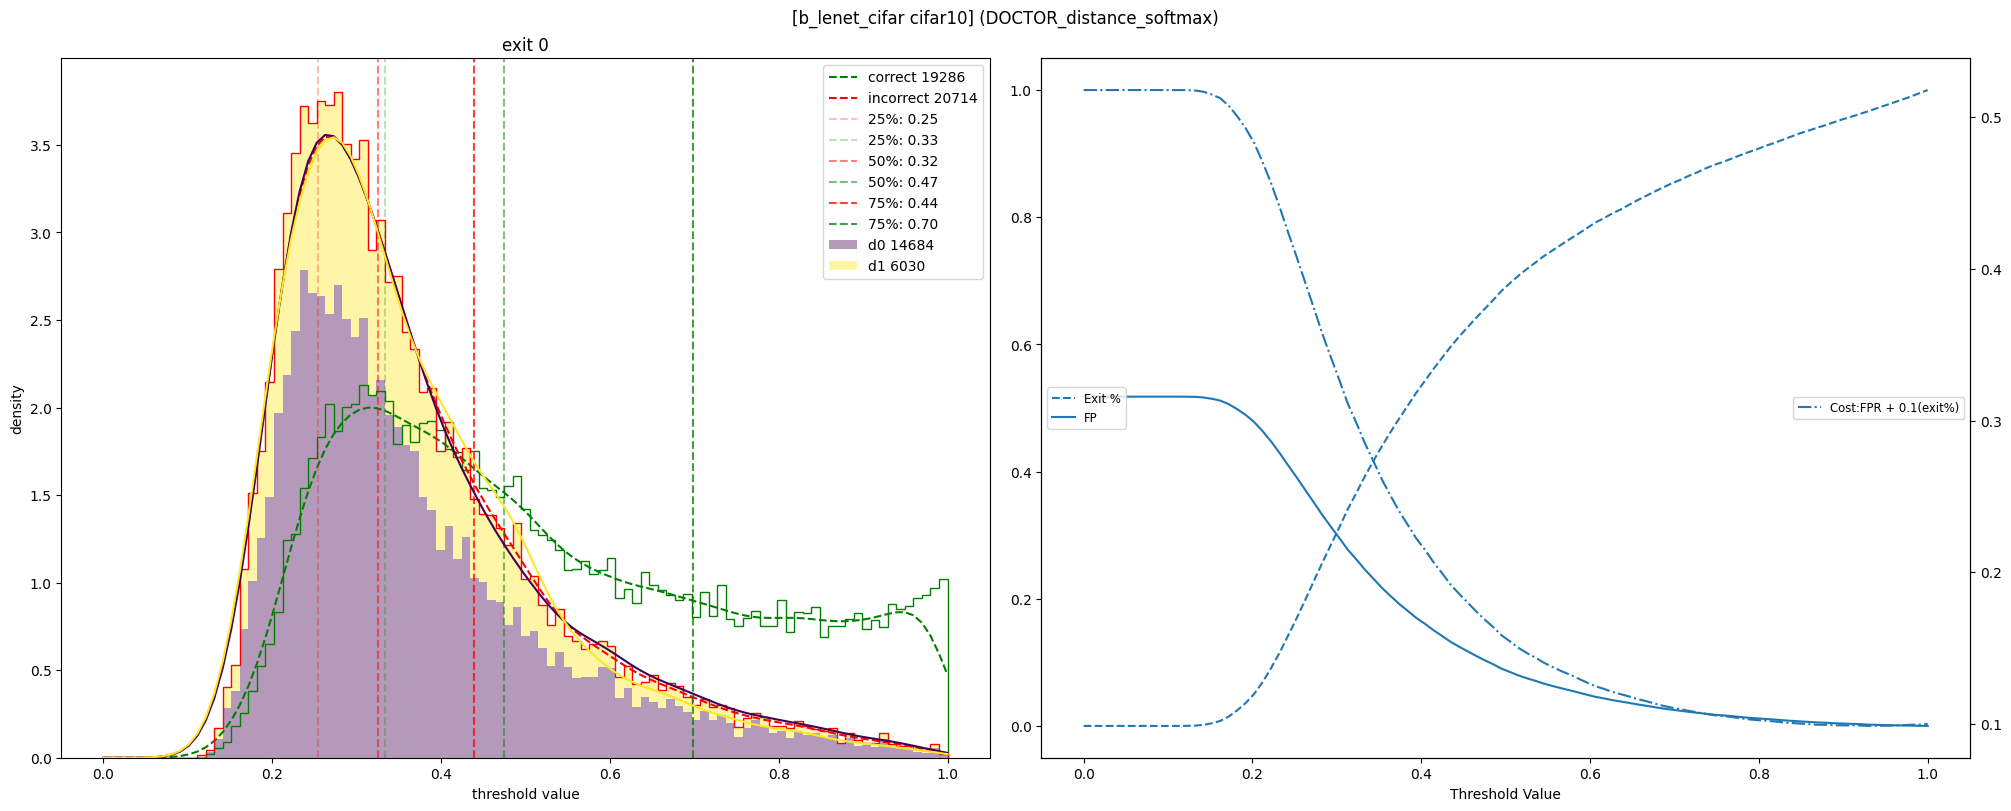

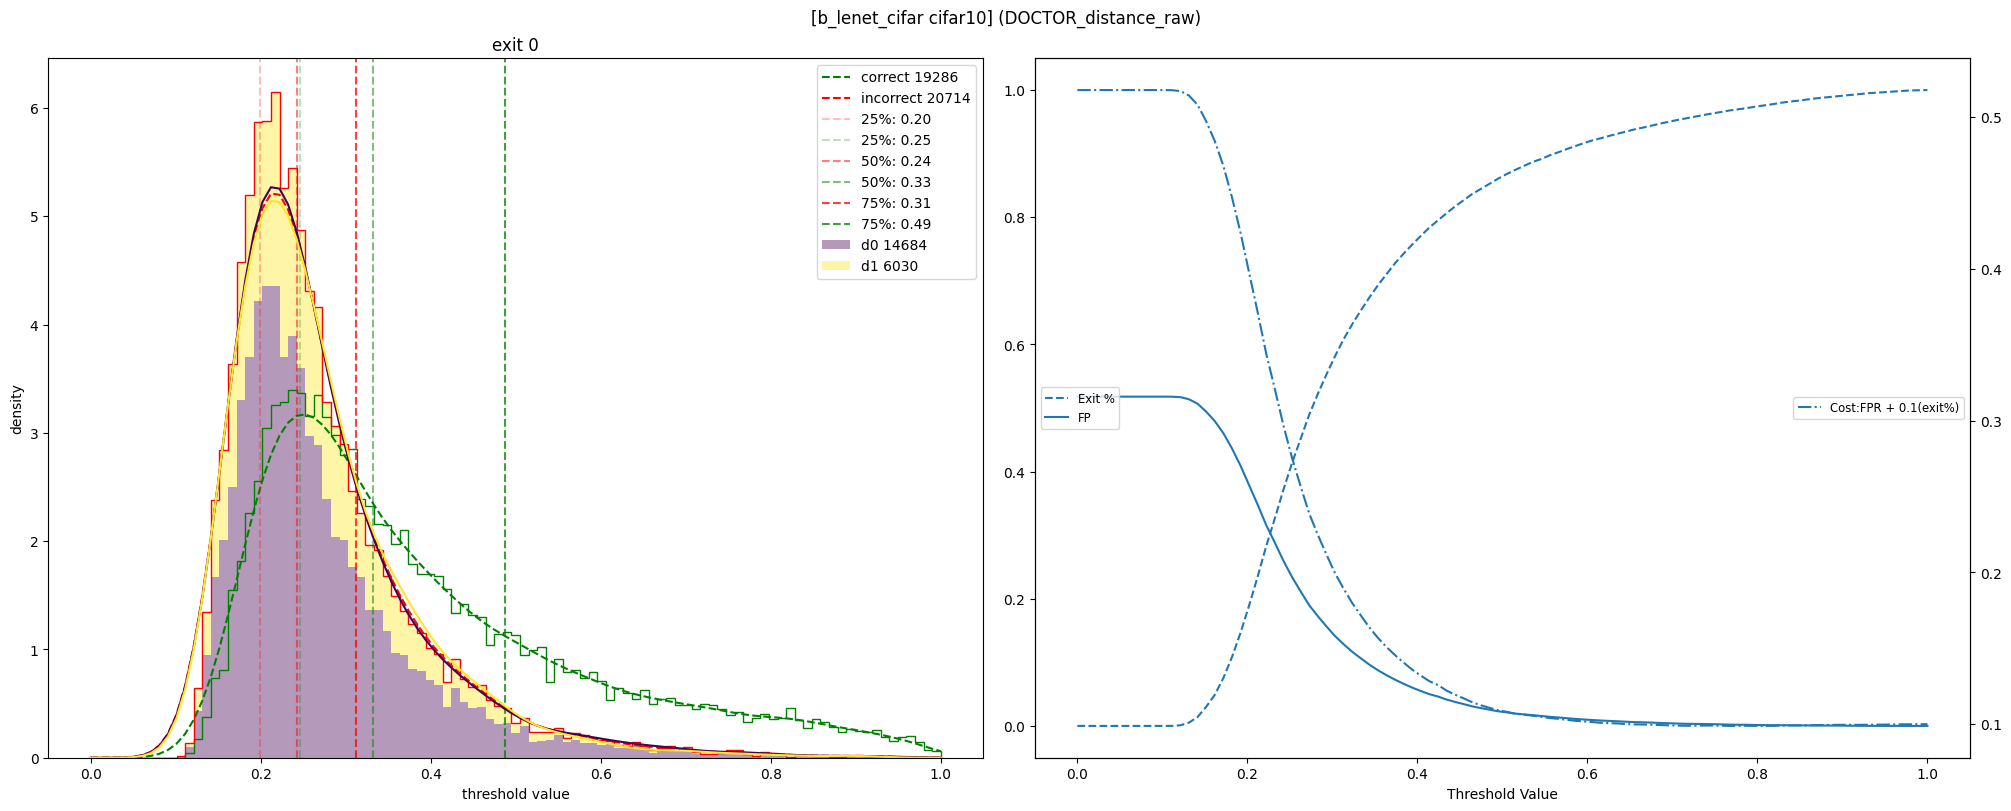

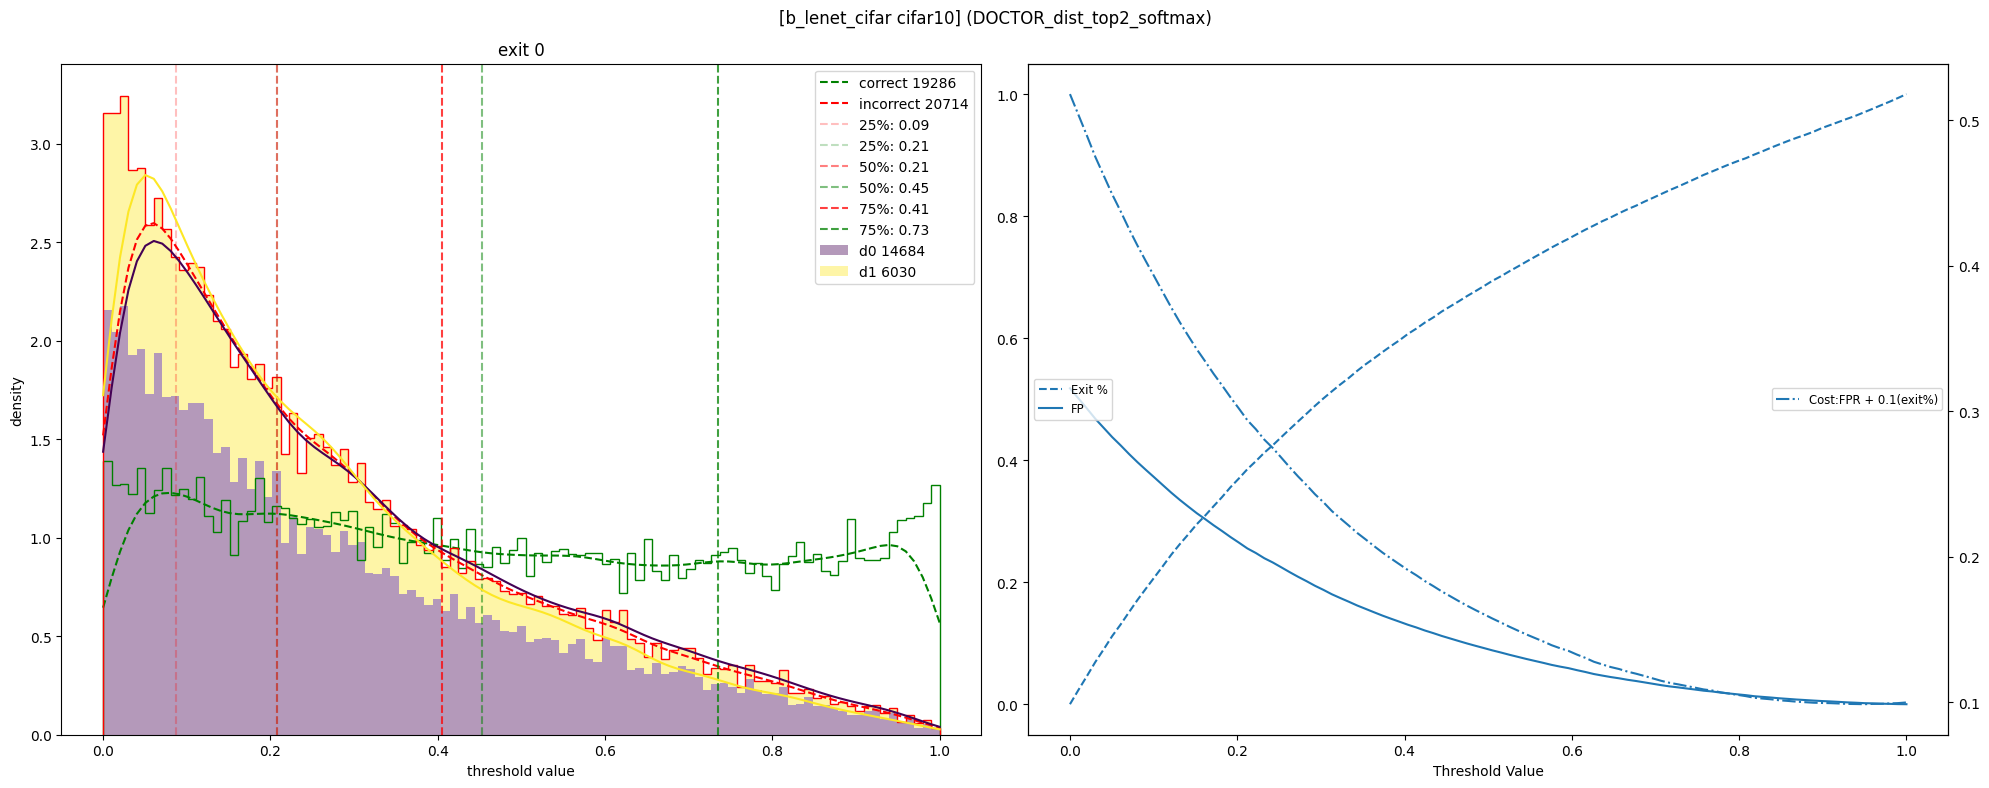

In [9]:
# Checking to see if there is some code to reuse in data_analysis

from earlyexitnet.data_analysis.softmax_comparison import main as sftmxcmp_main

sftmxcmp_main(full_dest) #funcs=None, plot_classes=False <- defaults
